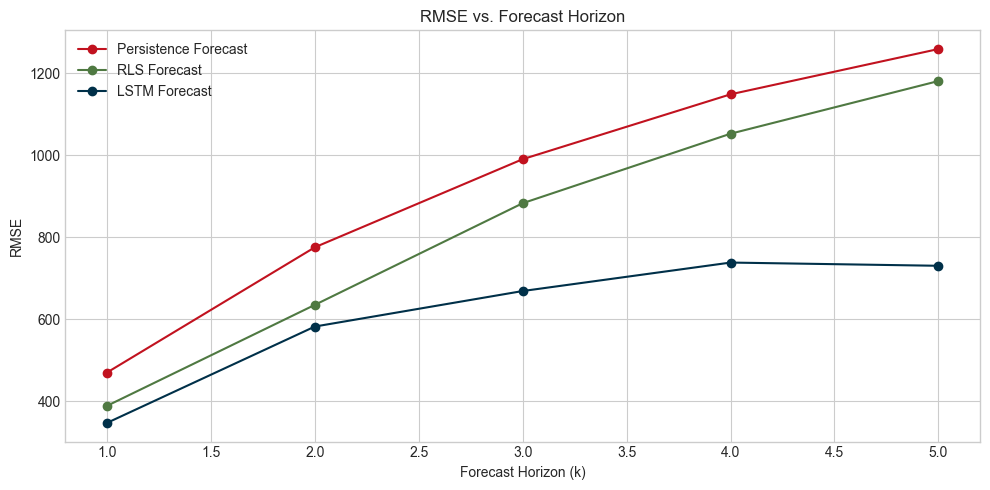


RMSE values by model:
Persistence Forecast: {1: 469.876, 2: 775.435, 3: 990.36, 4: 1148.591, 5: 1259.075}
RLS Forecast: {1: 388.645, 2: 634.976, 3: 882.941, 4: 1052.502, 5: 1180.981}
LSTM Forecast: {1: 347.033, 2: 582.078, 3: 668.711, 4: 738.155, 5: 730.297}

Extreme RMSE by model (top 10% obs):
Persistence: {1: 857.897, 2: 1134.963, 3: 1328.355, 4: 1534.897, 5: 1743.086}
RLS:        {1: 749.918, 2: 957.093, 3: 1201.63, 4: 1423.02, 5: 1633.416}
LSTM avg:   {1: 686.537, 2: 1366.902, 3: 1577.261, 4: 1696.129, 5: 1665.22}


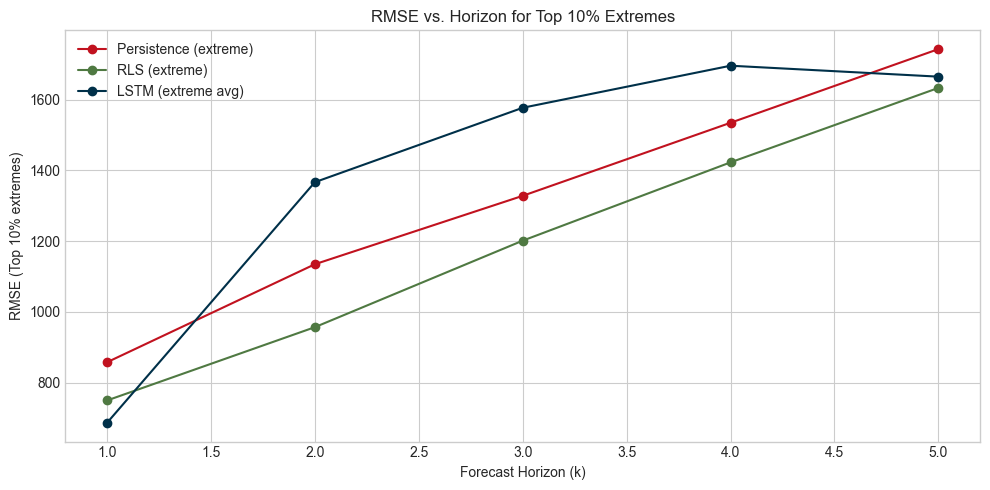

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# Global Settings & Colors
# -------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
colors = {
    "barn_red": "#780000",
    "fire_brick": "#c1121f",
    "fern_green": "#4F7942",
    "prussian_blue": "#003049"
}

# -------------------------------
# Helper Functions
# -------------------------------
def low_pass(series, a1=0.9):
    return series.ewm(alpha=1 - a1, adjust=False).mean().values

def rls_initialize(n_params, delta=1000):
    return np.zeros(n_params), delta * np.eye(n_params)

def rls_update(theta, P, x_t, y_t, lam):
    xcol = x_t.reshape(-1, 1)
    denom = lam + (xcol.T @ P @ xcol).item()
    K = (P @ xcol) / denom
    err = y_t - (xcol.T @ theta.reshape(-1, 1)).item()
    theta = theta + (K.flatten() * err)
    P = (P - K @ xcol.T @ P) / lam
    return theta, P

def online_rls_k(df, lam, a1, delta, k, extra_features=None):
    D = df.copy()
    D['t'] = pd.to_datetime(D['time'])
    D.set_index('t', inplace=True)

    y_arr = D['KarupBro'].values
    prec = D['precip_total_daily'].values
    n = len(D); m = k - 1

    # baseline precip forecast
    prec_pred = np.full(n, np.nan)
    prec_pred[:n - m] = prec[m:]
    prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

    # lag-1 inflow
    y_lag1 = np.full(n, np.nan)
    y_lag1[1:] = y_arr[:-1]

    # extra features
    extra_preds = {}
    if extra_features:
        for f in extra_features:
            arr = D[f].values
            arr_pred = np.full(n, np.nan)
            arr_pred[:n - m] = arr[m:]
            if f == 'precip_total_daily':
                arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
            extra_preds[f] = arr_pred

    # initialize RLS
    n_params = 3 + (len(extra_features) if extra_features else 0)
    theta, P = rls_initialize(n_params, delta)

    # online predict + update
    yhat = np.full(n, np.nan)
    for t in range(m + 1, n):
        x = [1.0, y_lag1[t], prec_lp[t]]
        if extra_features:
            for f in extra_features:
                x.append(extra_preds[f][t])
        x_t = np.array(x)
        yhat[t] = x_t @ theta
        if not np.isnan(y_arr[t]):
            theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

    return pd.Series(yhat, index=D.index, name=f'k{k}')

def score(residuals, mask=None):
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def plot_rmse(rmse_dict, horizons):
    fig, ax = plt.subplots(figsize=(10, 5))
    model_colors = {
        "Persistence Forecast": colors["fire_brick"],
        "RLS Forecast": colors["fern_green"],
        "LSTM Forecast": colors["prussian_blue"]
    }
    for model_name, rmse in rmse_dict.items():
        ax.plot(horizons, rmse.values, marker='o', label=model_name,
                color=model_colors.get(model_name, 'black'))
    ax.set_xlabel("Forecast Horizon (k)")
    ax.set_ylabel("RMSE")
    ax.set_title("RMSE vs. Forecast Horizon")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print("\nRMSE values by model:")
    for model_name, rmse in rmse_dict.items():
        print(f"{model_name}: {rmse.round(3).to_dict()}")

def persistence(df, horizons):
    forecasts = pd.DataFrame(index=df.index)
    for k in horizons:
        forecasts[f'k{k}'] = df['y'].shift(1)
    return forecasts

def create_offline_dataset(df, window_size, k, hist_cols, fcst_cols):
    Xh, Xf, y_arr, idxs = [], [], [], []
    n = len(df)
    for i in range(window_size, n - (k - 1)):
        idx = i + (k - 1)
        Xh.append(df[hist_cols].iloc[i - window_size:i].values.astype(np.float32))
        Xf.append(df[fcst_cols].iloc[idx].values.astype(np.float32))
        y_arr.append(float(df['y'].iloc[idx]))
        idxs.append(df.index[idx])
    return np.stack(Xh), np.stack(Xf), np.array(y_arr), np.array(idxs)

def build_model(window_size, n_hist, n_fcst):
    hist_input = Input(shape=(window_size, n_hist))
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    fcst_input = Input(shape=(n_fcst,))
    yb = Dense(32, activation='relu')(fcst_input)
    yb = Dense(32, activation='relu')(yb)
    combined = Concatenate()([x, yb])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    m = Model([hist_input, fcst_input], output)
    m.compile(optimizer=Adam(0.001), loss='mse')
    return m

# -------------------------------
# Data Loading & Preprocessing
# -------------------------------
data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
D = pd.read_csv(data_path)

D['t'] = pd.to_datetime(D['time'])
D = D.set_index('t').sort_index()
D['y'] = D['KarupBro']

# Clean outliers & interpolate
D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0
D['temp_mean_daily'].interpolate(inplace=True)
D['precip_total_daily'].fillna(0, inplace=True)

# static forecast inputs
D['precip_forecast'] = low_pass(D['precip_total_daily'], a1=0.9)
D['Year_sin'] = np.sin(2 * np.pi * D.index.dayofyear / 365)
D['Year_cos'] = np.cos(2 * np.pi * D.index.dayofyear / 365)

score_period = D.index[-1023:]
score_start = score_period[0]

# -------------------------------
# Forecasting Configs
# -------------------------------
horizons = [1, 2, 3, 4, 5]
window_size = 10
runs = 10
delta = 1000

# RLS hyper‐parameters per horizon
rls_params = {
    1: {'extra_features': ['radiation_global_daily', 'precip_duration_daily'],     'lam': 0.95, 'a1': 0.5},
    2: {'extra_features': ['precip_duration_daily', 'temp_soil_mean_daily'],      'lam': 0.95, 'a1': 0.7},
    3: {'extra_features': ['precip_duration_daily', 'temp_soil_mean_daily'],      'lam': 0.99, 'a1': 0.8},
    4: {'extra_features': ['temp_soil_min_daily', 'precip_duration_daily'],       'lam': 0.99, 'a1': 0.8},
    5: {'extra_features': ['temp_soil_max_daily', 'precip_duration_daily'],       'lam': 0.99, 'a1': 0.9},
}

# LSTM extra features per horizon
lstm_features = {
    1: ['temp_max_daily', 'temp_soil_max_daily', 'wind_speed_daily', 'temp_grass_mean_daily'],
    2: ['temp_max_daily', 'temp_soil_max_daily'],
    3: ['temp_max_daily', 'temp_min_daily'],
    4: ['temp_max_daily', 'ET0'],
    5: ['temp_grass_mean_daily', 'wind_gust_max_daily', 'temp_soil_mean_daily', 'precip_duration_daily', 'wind_direction_daily']
}

# common LSTM forecast cols
lstm_fcst_base = ['precip_forecast', 'Year_sin', 'Year_cos']

# -------------------------------
# RLS Forecasting
# -------------------------------
YhatR = pd.DataFrame(index=D.index)
for k in horizons:
    p = rls_params[k]
    YhatR[f'k{k}'] = online_rls_k(
        D.reset_index(), 
        lam=p['lam'], 
        a1=p['a1'], 
        delta=delta, 
        k=k, 
        extra_features=p['extra_features']
    )

# -------------------------------
# LSTM Forecasting with avg over runs
# -------------------------------
all_rmse_LSTM = []
all_extreme_rmse_LSTM = []
final_lstm_forecasts = {}

for run in range(runs):
    run_rmse = {}
    run_extreme_rmse = {}
    for k in horizons:
        # set per-horizon hist & fcst columns
        hist_cols_k = ['y', 'precip_total_daily', 'Year_sin', 'Year_cos'] + lstm_features[k]
        fcst_cols_k = lstm_fcst_base

        Xh, Xf, y_arr, idxs = create_offline_dataset(D, window_size, k, hist_cols_k, fcst_cols_k)
        mask_test = idxs >= score_start
        Xh_tr, Xh_te = Xh[~mask_test], Xh[mask_test]
        Xf_tr, Xf_te = Xf[~mask_test], Xf[mask_test]
        y_tr, y_te = y_arr[~mask_test], y_arr[mask_test]

        model = build_model(window_size, Xh.shape[2], Xf.shape[1])
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit([Xh_tr, Xf_tr], y_tr,
                  validation_split=0.2, epochs=50, batch_size=32,
                  verbose=0, callbacks=[es])

        preds = model.predict([Xh_te, Xf_te], verbose=0).flatten()
        run_rmse[k] = np.sqrt(np.nanmean((y_te - preds)**2))
        thr = np.quantile(y_te, 0.9)
        mask_ext = y_te >= thr
        run_extreme_rmse[k] = (np.sqrt(np.nanmean((y_te[mask_ext] - preds[mask_ext])**2))
                               if mask_ext.sum() > 0 else np.nan)

        if run == runs - 1:
            final_lstm_forecasts[f'k{k}'] = pd.Series(preds, index=idxs[mask_test])

    all_rmse_LSTM.append(pd.Series(run_rmse))
    all_extreme_rmse_LSTM.append(pd.Series(run_extreme_rmse))

avg_rmse_LSTM = pd.concat(all_rmse_LSTM, axis=1).mean(axis=1)
avg_extreme_rmse_LSTM = pd.concat(all_extreme_rmse_LSTM, axis=1).mean(axis=1)

# -------------------------------
# Persistence Forecasting
# -------------------------------
YhatP = persistence(D, horizons)

# -------------------------------
# RMSE Evaluation (Full Period)
# -------------------------------
targets = {k: D['y'].shift(-(k - 1)) for k in horizons}
mask = D.index.isin(score_period)

rmse_P = pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask=mask) for k in horizons})
rmse_R = pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask=mask) for k in horizons})
rmse_LSTM = avg_rmse_LSTM

rmse_dict = {
    'Persistence Forecast': rmse_P,
    'RLS Forecast': rmse_R,
    'LSTM Forecast': rmse_LSTM
}

# -------------------------------
# Plot & Print RMSE
# -------------------------------
plot_rmse(rmse_dict, horizons)

# -------------------------------
# Extreme RMSE (Top 10%)
# -------------------------------
threshold = np.percentile(D.loc[score_period, 'y'], 90)
mask_extreme = D['y'].ge(threshold) & D.index.isin(score_period)

print("\nExtreme RMSE by model (top 10% obs):")
print("Persistence:", {k: score(YhatP[f'k{k}'] - targets[k], mask=mask_extreme).round(3) for k in horizons})
print("RLS:       ", {k: score(YhatR[f'k{k}'] - targets[k], mask=mask_extreme).round(3) for k in horizons})
print("LSTM avg:  ", avg_extreme_rmse_LSTM.round(3).to_dict())

# -------------------------------
# Plot Extreme RMSE vs Horizon
# -------------------------------
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(horizons, 
        [score(YhatP[f'k{k}'] - targets[k], mask=mask_extreme) for k in horizons],
        marker='o', label='Persistence (extreme)', color=colors['fire_brick'])
ax.plot(horizons, 
        [score(YhatR[f'k{k}'] - targets[k], mask=mask_extreme) for k in horizons],
        marker='o', label='RLS (extreme)',        color=colors['fern_green'])
ax.plot(horizons, avg_extreme_rmse_LSTM.values,
        marker='o', label='LSTM (extreme avg)',  color=colors['prussian_blue'])
ax.set_xlabel('Forecast Horizon (k)')
ax.set_ylabel('RMSE (Top 10% extremes)')
ax.set_title('RMSE vs. Horizon for Top 10% Extremes')
ax.legend()
plt.tight_layout()
plt.show()

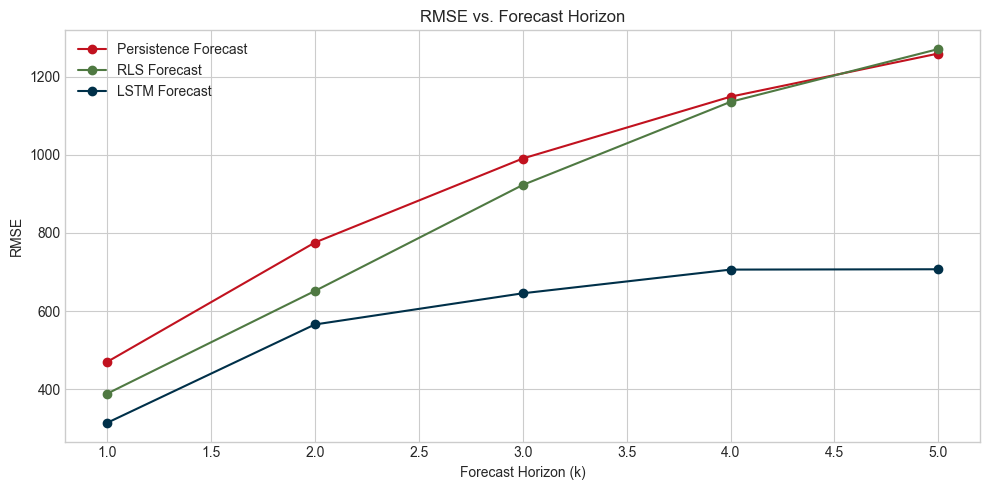


RMSE values by model:
Persistence Forecast: {1: 469.876, 2: 775.435, 3: 990.36, 4: 1148.591, 5: 1259.075}
RLS Forecast: {1: 388.645, 2: 651.513, 3: 922.674, 4: 1135.411, 5: 1270.528}
LSTM Forecast: {1: 314.043, 2: 565.792, 3: 645.582, 4: 706.217, 5: 707.084}

Extreme RMSE values by model (average over runs for LSTM):
Persistence (extreme): {1: 857.897, 2: 1134.963, 3: 1328.355, 4: 1534.897, 5: 1743.086}
RLS (extreme):        {1: 749.918, 2: 967.277, 3: 1293.184, 4: 1593.808, 5: 1780.651}
LSTM (extreme):      {1: 626.097, 2: 1262.032, 3: 1458.088, 4: 1554.029, 5: 1460.42}


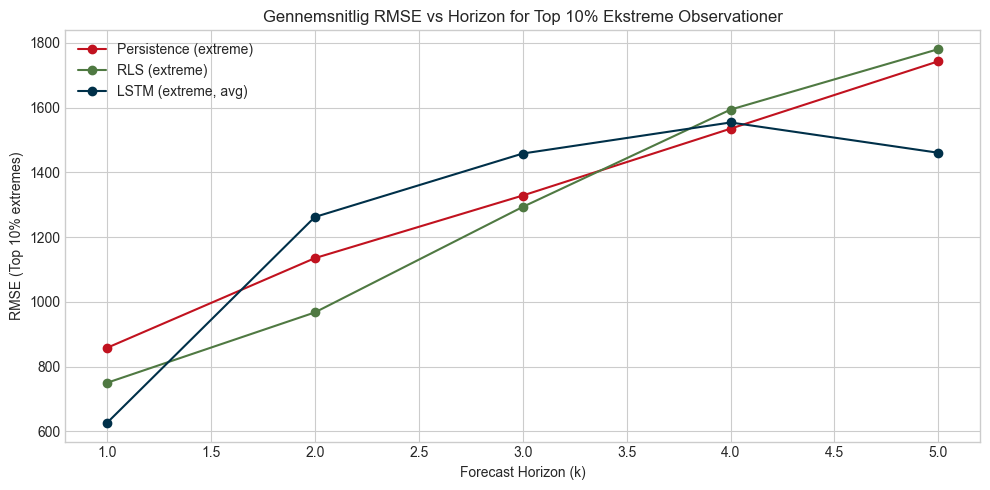

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# Global Settings & Colors
# -------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
colors = {
    "barn_red": "#780000",
    "fire_brick": "#c1121f",
    "fern_green": "#4F7942",
    "prussian_blue": "#003049"
}

# -------------------------------
# Helper Functions
# -------------------------------
def low_pass(series, a1=0.9):
    return series.ewm(alpha=1 - a1, adjust=False).mean().values

def rls_initialize(n_params, delta=1000):
    return np.zeros(n_params), delta * np.eye(n_params)

def rls_update(theta, P, x_t, y_t, lam):
    xcol = x_t.reshape(-1, 1)
    denom = lam + (xcol.T @ P @ xcol).item()
    K = (P @ xcol) / denom
    err = y_t - (xcol.T @ theta.reshape(-1, 1)).item()
    theta = theta + (K.flatten() * err)
    P = (P - K @ xcol.T @ P) / lam
    return theta, P

def online_rls_k(df, lam, a1, delta, k, extra_features=None):
    D = df.copy()
    D['t'] = pd.to_datetime(D['time'])
    D.set_index('t', inplace=True)

    y_arr = D['KarupBro'].values
    prec = D['precip_total_daily'].values
    n = len(D); m = k - 1

    # baseline precip forecast
    prec_pred = np.full(n, np.nan)
    prec_pred[:n - m] = prec[m:]
    prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

    # lag-1 inflow
    y_lag1 = np.full(n, np.nan)
    y_lag1[1:] = y_arr[:-1]

    # extra features
    extra_preds = {}
    if extra_features:
        for f in extra_features:
            arr = D[f].values
            arr_pred = np.full(n, np.nan)
            arr_pred[:n - m] = arr[m:]
            if f == 'precip_total_daily':
                arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
            extra_preds[f] = arr_pred

    # initialize RLS
    n_params = 3 + (len(extra_features) if extra_features else 0)
    theta, P = rls_initialize(n_params, delta)

    # online predict + update
    yhat = np.full(n, np.nan)
    for t in range(m + 1, n):
        x = [1.0, y_lag1[t], prec_lp[t]]
        if extra_features:
            for f in extra_features:
                x.append(extra_preds[f][t])
        x_t = np.array(x)
        yhat[t] = x_t @ theta
        if not np.isnan(y_arr[t]):
            theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

    return pd.Series(yhat, index=D.index, name=f'k{k}')

def score(residuals, mask=None):
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def plot_rmse(rmse_dict, horizons):
    fig, ax = plt.subplots(figsize=(10, 5))
    model_colors = {
        "Persistence Forecast": colors["fire_brick"],
        "RLS Forecast": colors["fern_green"],
        "LSTM Forecast": colors["prussian_blue"]
    }
    for model_name, rmse in rmse_dict.items():
        ax.plot(horizons, rmse.values, marker='o', label=model_name,
                color=model_colors.get(model_name, 'black'))
    ax.set_xlabel("Forecast Horizon (k)")
    ax.set_ylabel("RMSE")
    ax.set_title("RMSE vs. Forecast Horizon")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print("\nRMSE values by model:")
    for model_name, rmse in rmse_dict.items():
        print(f"{model_name}: {rmse.round(3).to_dict()}")

def persistence(df, horizons):
    forecasts = pd.DataFrame(index=df.index)
    for k in horizons:
        forecasts[f'k{k}'] = df['y'].shift(1)
    return forecasts

# -------------------------------
# Offline Dataset & Model Builder
# -------------------------------
def create_offline_dataset(df, window_size, k, hist_cols, fcst_cols):
    Xh, Xf, y_arr, idxs = [], [], [], []
    n = len(df)
    for i in range(window_size, n - (k - 1)):
        idx = i + (k - 1)
        Xh.append(df[hist_cols].iloc[i - window_size:i].values.astype(np.float32))
        Xf.append(df[fcst_cols].iloc[idx].values.astype(np.float32))
        y_arr.append(float(df['y'].iloc[idx]))
        idxs.append(df.index[idx])
    return np.stack(Xh), np.stack(Xf), np.array(y_arr), np.array(idxs)

def build_model(window_size, n_hist, n_fcst):
    hist_input = Input(shape=(window_size, n_hist))
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    fcst_input = Input(shape=(n_fcst,))
    yb = Dense(32, activation='relu')(fcst_input)
    yb = Dense(32, activation='relu')(yb)
    combined = Concatenate()([x, yb])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    m = Model([hist_input, fcst_input], output)
    m.compile(optimizer=Adam(0.001), loss='mse')
    return m

# -------------------------------
# Data Loading & Preprocessing
# -------------------------------
data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
D = pd.read_csv(data_path)

D['t'] = pd.to_datetime(D['time'])
D = D.set_index('t').sort_index()
D['y'] = D['KarupBro']

D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0
D['temp_mean_daily'].interpolate(inplace=True)
D['precip_total_daily'].fillna(0, inplace=True)

D['temp_forecast'] = D['temp_mean_daily']
D['precip_forecast'] = low_pass(D['precip_total_daily'], a1=0.9)
D['Year_sin'] = np.sin(2 * np.pi * D.index.dayofyear / 365)
D['Year_cos'] = np.cos(2 * np.pi * D.index.dayofyear / 365)

score_period = D.index[-1023:]
score_start = score_period[0]

# -------------------------------
# Forecasting Configs
# -------------------------------
horizons = [1, 2, 3, 4, 5]
window_size = 10
runs = 10

rls_features = ['radiation_global_daily', 'precip_duration_daily']
lam_opt = 0.95
a1_opt = 0.5
delta = 1000

lstm_hist_base = ['y', 'precip_total_daily', 'Year_sin', 'Year_cos']
lstm_fcst_base = ['precip_forecast', 'Year_sin', 'Year_cos']
lstm_extra = ['temp_min_daily', 'wind_speed_daily', 'precip_duration_daily']
hist_cols = lstm_hist_base + lstm_extra
fcst_cols = lstm_fcst_base + lstm_extra

# -------------------------------
# RLS Forecasting
# -------------------------------
YhatR = pd.DataFrame(index=D.index)
for k in horizons:
    YhatR[f'k{k}'] = online_rls_k(D.reset_index(), lam_opt, a1_opt, delta, k, extra_features=rls_features)

# -------------------------------
# LSTM Forecasting with avg over runs
# -------------------------------
all_rmse_LSTM = []
all_extreme_rmse_LSTM = []
final_lstm_forecasts = {}

for run in range(runs):
    run_rmse = {}
    run_extreme_rmse = {}
    for k in horizons:
        Xh, Xf, y_arr, idxs = create_offline_dataset(D, window_size, k, hist_cols, fcst_cols)
        mask_test = idxs >= score_start
        Xh_tr, Xh_te = Xh[~mask_test], Xh[mask_test]
        Xf_tr, Xf_te = Xf[~mask_test], Xf[mask_test]
        y_tr, y_te = y_arr[~mask_test], y_arr[mask_test]

        model = build_model(window_size, Xh.shape[2], Xf.shape[1])
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit([Xh_tr, Xf_tr], y_tr,
                  validation_split=0.2, epochs=50, batch_size=16,
                  verbose=0, callbacks=[es])

        preds = model.predict([Xh_te, Xf_te], verbose=0).flatten()
        # full-period RMSE
        run_rmse[k] = np.sqrt(np.nanmean((y_te - preds)**2))
        # extreme RMSE (top 10%)
        thr = np.quantile(y_te, 0.9)
        mask_ext = y_te >= thr
        run_extreme_rmse[k] = np.sqrt(np.nanmean((y_te[mask_ext] - preds[mask_ext])**2)) if mask_ext.sum()>0 else np.nan

        if run == runs - 1:
            final_lstm_forecasts[f'k{k}'] = pd.Series(preds, index=idxs[mask_test])

    all_rmse_LSTM.append(pd.Series(run_rmse))
    all_extreme_rmse_LSTM.append(pd.Series(run_extreme_rmse))

avg_rmse_LSTM = pd.concat(all_rmse_LSTM, axis=1).mean(axis=1)
avg_extreme_rmse_LSTM = pd.concat(all_extreme_rmse_LSTM, axis=1).mean(axis=1)

# -------------------------------
# Persistence Forecasting
# -------------------------------
YhatP = persistence(D, horizons)

# -------------------------------
# RMSE Evaluation (Full Period)
# -------------------------------
targets = {k: D['y'].shift(-(k - 1)) for k in horizons}
mask = D.index.isin(score_period)

rmse_P = pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask=mask) for k in horizons})
rmse_R = pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask=mask) for k in horizons})
rmse_LSTM = avg_rmse_LSTM

rmse_dict = {
    'Persistence Forecast': rmse_P,
    'RLS Forecast': rmse_R,
    'LSTM Forecast': rmse_LSTM
}

# -------------------------------
# Plot & Print RMSE
# -------------------------------
plot_rmse(rmse_dict, horizons)

# -------------------------------
# Print Extreme RMSE Values by Model
# -------------------------------
print("\nExtreme RMSE values by model (average over runs for LSTM):")
print(f"Persistence (extreme): {pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask=mask & (D['y']>=np.percentile(D.loc[score_period,'y'],90))) for k in horizons}).round(3).to_dict()}")
print(f"RLS (extreme):        {pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask=mask & (D['y']>=np.percentile(D.loc[score_period,'y'],90))) for k in horizons}).round(3).to_dict()}")
print(f"LSTM (extreme):      {avg_extreme_rmse_LSTM.round(3).to_dict()}")

# -------------------------------
# Plot Extreme RMSE vs Horizon
# -------------------------------
threshold = np.percentile(D.loc[score_period, 'y'], 90)
mask_extreme = D['y'].ge(threshold) & D.index.isin(score_period)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(horizons, 
        [score(YhatP[f'k{k}'] - targets[k], mask_extreme) for k in horizons],
        marker='o', label='Persistence (extreme)', color=colors['fire_brick'])
ax.plot(horizons, 
        [score(YhatR[f'k{k}'] - targets[k], mask_extreme) for k in horizons],
        marker='o', label='RLS (extreme)',        color=colors['fern_green'])
ax.plot(horizons, avg_extreme_rmse_LSTM.values,
        marker='o', label='LSTM (extreme, avg)', color=colors['prussian_blue'])
ax.set_xlabel('Forecast Horizon (k)')
ax.set_ylabel('RMSE (Top 10% extremes)')
ax.set_title('Gennemsnitlig RMSE vs Horizon for Top 10% Ekstreme Observationer')
ax.legend(); plt.tight_layout(); plt.show()

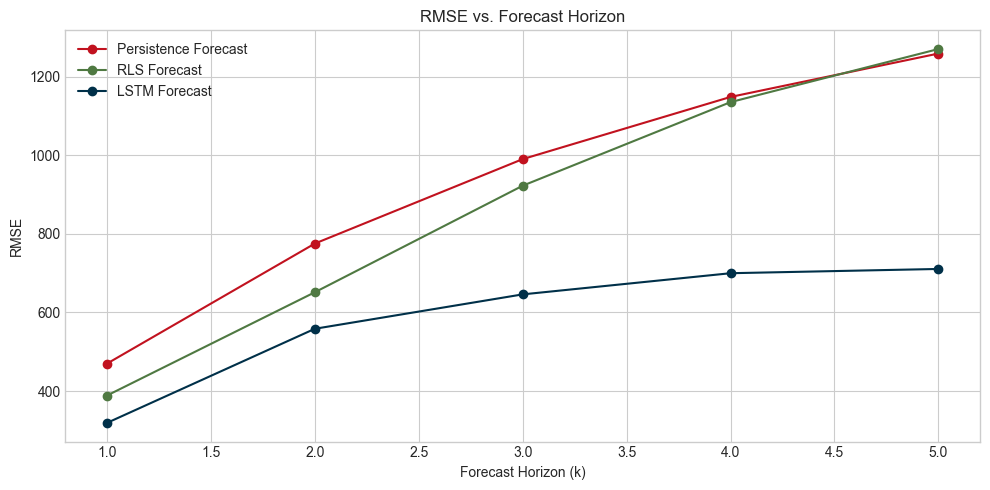


RMSE values by model:
Persistence Forecast: {'k1': 469.876, 'k2': 775.435, 'k3': 990.36, 'k4': 1148.591, 'k5': 1259.075}
RLS Forecast: {'k1': 388.645, 'k2': 651.513, 'k3': 922.674, 'k4': 1135.411, 'k5': 1270.528}
LSTM Forecast: {'k1': 319.01, 'k2': 558.533, 'k3': 646.096, 'k4': 699.953, 'k5': 710.79}


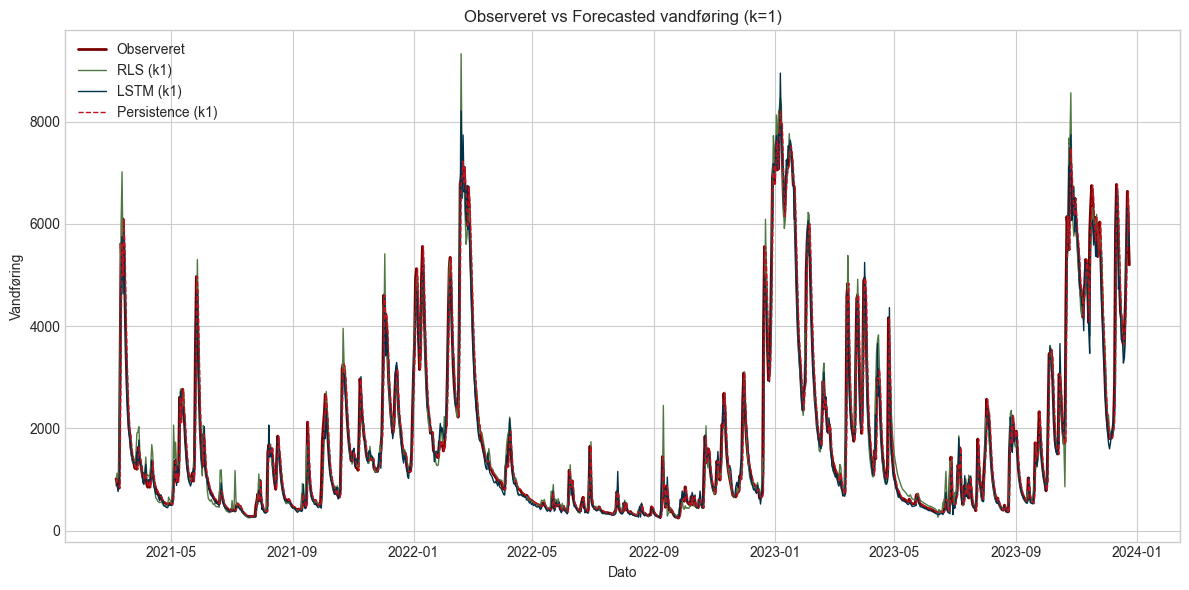

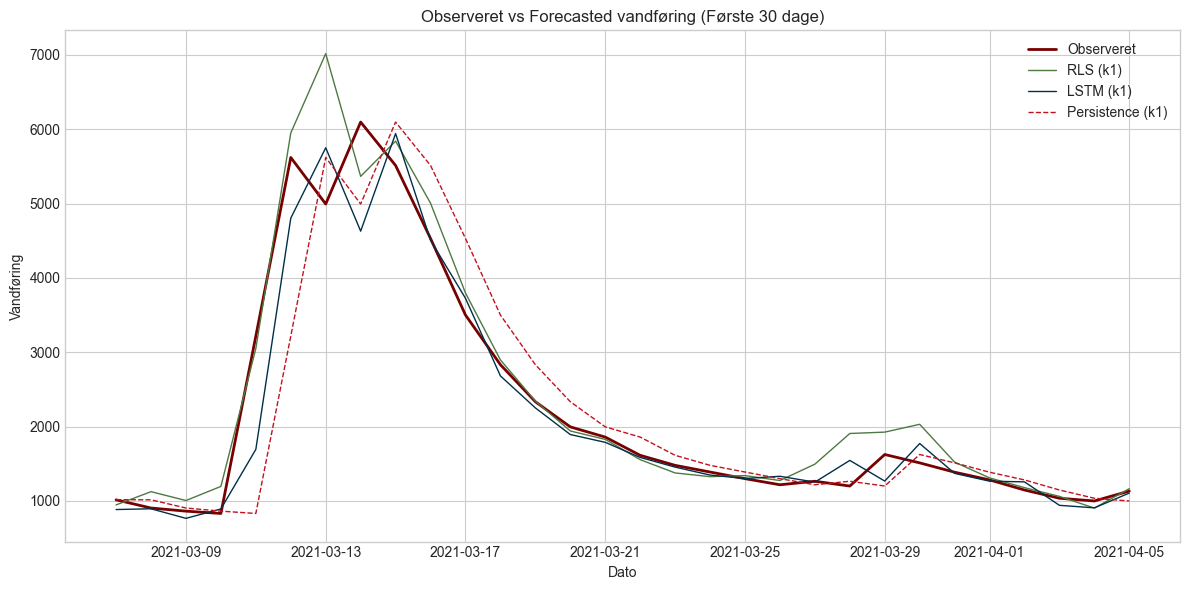

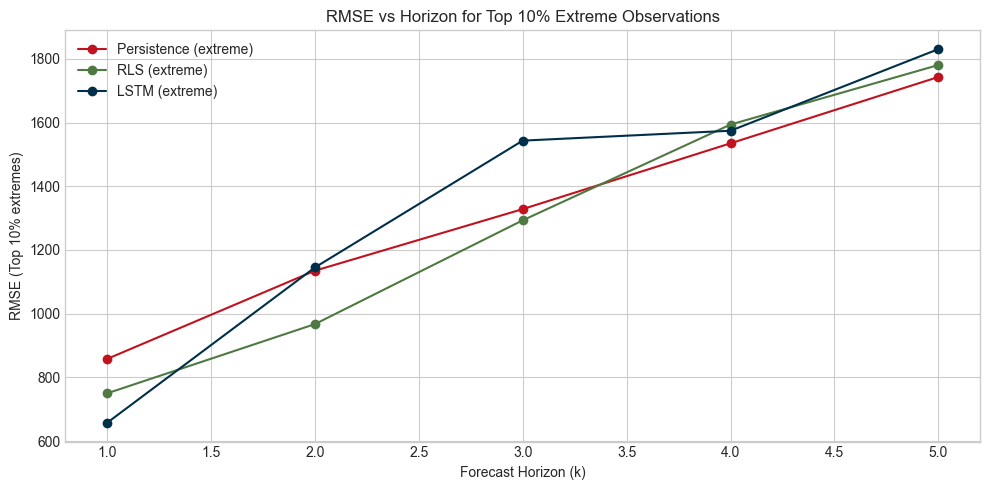

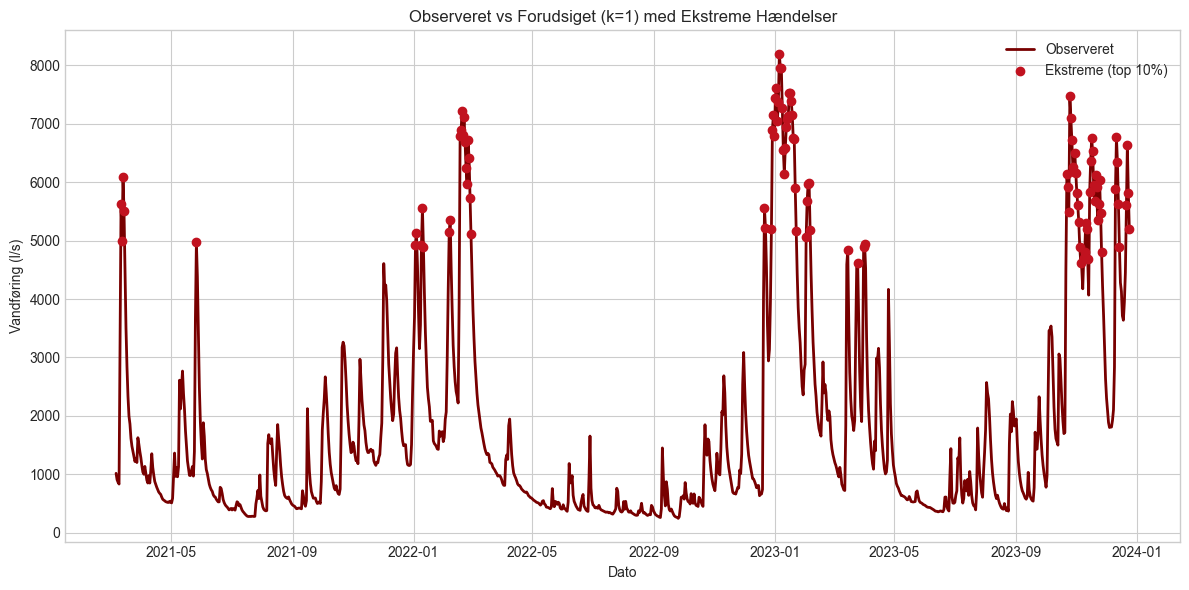

In [ ]:
# Updated Forecasting Code with Separate Feature Sets for RLS and LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# Global Settings & Colors
# -------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
colors = {
    "barn_red": "#780000",
    "fire_brick": "#c1121f",
    "fern_green": "#4F7942",
    "prussian_blue": "#003049"
}

# -------------------------------
# Helper Functions
# -------------------------------
def low_pass(series, a1=0.9):
    return series.ewm(alpha=1 - a1, adjust=False).mean().values

def rls_initialize(n_params, delta=1000):
    return np.zeros(n_params), delta * np.eye(n_params)

def rls_update(theta, P, x_t, y_t, lam):
    xcol = x_t.reshape(-1, 1)
    denom = lam + (xcol.T @ P @ xcol).item()
    K = (P @ xcol) / denom
    err = y_t - (xcol.T @ theta.reshape(-1, 1)).item()
    theta = theta + (K.flatten() * err)
    P = (P - K @ xcol.T @ P) / lam
    return theta, P

def online_rls_k(df, lam, a1, delta, k, extra_features=None):
    D = df.copy()
    D['t'] = pd.to_datetime(D['time'])
    D.set_index('t', inplace=True)

    y_arr = D['KarupBro'].values
    prec = D['precip_total_daily'].values
    n = len(D); m = k - 1

    prec_pred = np.full(n, np.nan)
    prec_pred[:n - m] = prec[m:]
    prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

    y_lag1 = np.full(n, np.nan)
    y_lag1[1:] = y_arr[:-1]

    extra_preds = {}
    if extra_features:
        for f in extra_features:
            arr = D[f].values
            arr_pred = np.full(n, np.nan)
            arr_pred[:n - m] = arr[m:]
            if f == 'precip_total_daily':
                arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
            extra_preds[f] = arr_pred

    n_params = 3 + (len(extra_features) if extra_features else 0)
    theta, P = rls_initialize(n_params, delta)

    yhat = np.full(n, np.nan)
    for t in range(m + 1, n):
        x = [1.0, y_lag1[t], prec_lp[t]]
        if extra_features:
            for f in extra_features:
                x.append(extra_preds[f][t])
        x_t = np.array(x)
        yhat[t] = x_t @ theta
        if not np.isnan(y_arr[t]):
            theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

    return pd.Series(yhat, index=D.index, name=f'k{k}')

def score(residuals, mask=None):
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def plot_rmse(rmse_dict, horizons):
    fig, ax = plt.subplots(figsize=(10, 5))
    model_colors = {
        "Persistence Forecast": colors["fire_brick"],
        "RLS Forecast": colors["fern_green"],
        "LSTM Forecast": colors["prussian_blue"]
    }
    for model_name, rmse in rmse_dict.items():
        ax.plot(horizons, rmse.values, marker='o', label=model_name,
                color=model_colors.get(model_name, 'black'))
    ax.set_xlabel("Forecast Horizon (k)")
    ax.set_ylabel("RMSE")
    ax.set_title("RMSE vs. Forecast Horizon")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print("\nRMSE values by model:")
    for model_name, rmse in rmse_dict.items():
        print(f"{model_name}: {rmse.round(3).to_dict()}")

def persistence(df, horizons):
    forecasts = pd.DataFrame(index=df.index)
    for k in horizons:
        forecasts[f'k{k}'] = df['y'].shift(1)
    return forecasts

# -------------------------------
# Data Loading & Preprocessing
# -------------------------------
data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
D = pd.read_csv(data_path)

D['t'] = pd.to_datetime(D['time'])
D = D.set_index('t').sort_index()
D['y'] = D['KarupBro']

D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0
D['temp_mean_daily'].interpolate(inplace=True)
D['precip_total_daily'].fillna(0, inplace=True)

D['temp_forecast'] = D['temp_mean_daily']
D['precip_forecast'] = low_pass(D['precip_total_daily'], a1=0.9)
D['Year_sin'] = np.sin(2 * np.pi * D.index.dayofyear / 365)
D['Year_cos'] = np.cos(2 * np.pi * D.index.dayofyear / 365)

score_period = D.index[-1023:]
score_start = score_period[0]

# -------------------------------
# Forecasting Configs
# -------------------------------
horizons = [1, 2, 3, 4, 5]
window_size = 10
runs = 10

rls_features = ['radiation_global_daily', 'precip_duration_daily']
lam_opt = 0.95
a1_opt = 0.5
delta = 1000

lstm_hist_base = ['y', 'precip_total_daily', 'Year_sin', 'Year_cos']
lstm_fcst_base = ['precip_forecast', 'Year_sin', 'Year_cos']
lstm_extra = ['temp_min_daily', 'wind_speed_daily', 'precip_duration_daily']
hist_cols = lstm_hist_base + lstm_extra
fcst_cols = lstm_fcst_base + lstm_extra

# -------------------------------
# RLS Forecasting
# -------------------------------
YhatR = pd.DataFrame(index=D.index)
for k in horizons:
    YhatR[f'k{k}'] = online_rls_k(D.reset_index(), lam_opt, a1_opt, delta, k, extra_features=rls_features)

# -------------------------------
# LSTM Forecasting
# -------------------------------
def create_offline_dataset(df, window_size, k, hist_cols, fcst_cols):
    Xh, Xf, y_arr, idxs = [], [], [], []
    n = len(df)
    for i in range(window_size, n - (k - 1)):
        idx = i + (k - 1)
        Xh.append(df[hist_cols].iloc[i - window_size:i].values.astype(np.float32))
        Xf.append(df[fcst_cols].iloc[idx].values.astype(np.float32))
        y_arr.append(float(df['y'].iloc[idx]))
        idxs.append(df.index[idx])
    return np.stack(Xh), np.stack(Xf), np.array(y_arr), np.array(idxs)

def build_model(window_size, n_hist, n_fcst):
    hist_input = Input(shape=(window_size, n_hist))
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    fcst_input = Input(shape=(n_fcst,))
    yb = Dense(32, activation='relu')(fcst_input)
    yb = Dense(32, activation='relu')(yb)
    combined = Concatenate()([x, yb])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    m = Model([hist_input, fcst_input], output)
    m.compile(optimizer=Adam(0.001), loss='mse')
    return m

all_rmse_LSTM = []
final_lstm_forecasts = {}

for run in range(runs):
    run_rmse = {}
    for k in horizons:
        Xh, Xf, y_arr, idxs = create_offline_dataset(D, window_size, k, hist_cols, fcst_cols)
        mask_test = idxs >= score_start
        Xh_tr, Xh_te = Xh[~mask_test], Xh[mask_test]
        Xf_tr, Xf_te = Xf[~mask_test], Xf[mask_test]
        y_tr, y_te = y_arr[~mask_test], y_arr[mask_test]

        model = build_model(window_size, Xh.shape[2], Xf.shape[1])
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit([Xh_tr, Xf_tr], y_tr, validation_split=0.2,
                  epochs=50, batch_size=32, verbose=0, callbacks=[es])

        preds = model.predict([Xh_te, Xf_te], verbose=0).flatten()
        run_rmse[k] = np.sqrt(((y_te - preds)**2).mean())
        if run == runs - 1:
            final_lstm_forecasts[f'k{k}'] = pd.Series(preds, index=idxs[mask_test])

    all_rmse_LSTM.append(pd.Series(run_rmse))

avg_rmse_LSTM = pd.concat(all_rmse_LSTM, axis=1).mean(axis=1)

# -------------------------------
# Persistence Forecasting
# -------------------------------
YhatP = persistence(D, horizons)

# -------------------------------
# RMSE Evaluation (Full Period)
# -------------------------------
targets = {k: D['y'].shift(-(k - 1)) for k in horizons}
mask = D.index.isin(score_period)

rmse_P = pd.Series({f'k{k}': score(YhatP[f'k{k}'] - targets[k], mask=mask) for k in horizons})
rmse_R = pd.Series({f'k{k}': score(YhatR[f'k{k}'] - targets[k], mask=mask) for k in horizons})
rmse_LSTM = pd.Series({f'k{k}': avg_rmse_LSTM[k] for k in horizons})

rmse_dict = {
    'Persistence Forecast': rmse_P,
    'RLS Forecast': rmse_R,
    'LSTM Forecast': rmse_LSTM
}

# -------------------------------
# Plot RMSE (Full Period)
# -------------------------------
plot_rmse(rmse_dict, horizons)

# -------------------------------
# Plot Actual vs Predicted (k=1)
# -------------------------------
score_data = D.loc[score_period]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(score_data.index, score_data['y'], label='Observeret', color=colors['barn_red'], linewidth=2)
ax.plot(score_data.index,
        YhatR['k1'].reindex(score_data.index),
        label='RLS (k1)', color=colors['fern_green'], linewidth=1)
ax.plot(score_data.index,
        final_lstm_forecasts['k1'].reindex(score_data.index),
        label='LSTM (k1)', color=colors['prussian_blue'], linewidth=1)
ax.plot(score_data.index,
        YhatP['k1'].reindex(score_data.index),
        label='Persistence (k1)', color=colors['fire_brick'], linestyle='--', linewidth=1)
ax.set_xlabel('Dato'); ax.set_ylabel('Vandføring'); ax.set_title('Observeret vs Forecasted vandføring (k=1)')
ax.legend(); plt.tight_layout(); plt.show()

# First 30 days
short = score_data.iloc[:30]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(short.index, short['y'], label='Observeret', color=colors['barn_red'], linewidth=2)
ax.plot(short.index,
        YhatR['k1'].reindex(short.index),
        label='RLS (k1)', color=colors['fern_green'], linewidth=1)
ax.plot(short.index,
        final_lstm_forecasts['k1'].reindex(short.index),
        label='LSTM (k1)', color=colors['prussian_blue'], linewidth=1)
ax.plot(short.index,
        YhatP['k1'].reindex(short.index),
        label='Persistence (k1)', color=colors['fire_brick'], linestyle='--', linewidth=1)
ax.set_xlabel('Dato'); ax.set_ylabel('Vandføring'); ax.set_title('Observeret vs Forecasted vandføring (Første 30 dage)')
ax.legend(); plt.tight_layout(); plt.show()

# -------------------------------
# RMSE for Top 10% Extreme Observations
# -------------------------------
threshold = np.percentile(D.loc[score_period, 'y'], 90)
mask_extreme = D['y'].ge(threshold) & D.index.isin(score_period)

rmse_extreme_P = pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask_extreme) for k in horizons})
rmse_extreme_R = pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask_extreme) for k in horizons})
rmse_extreme_L = pd.Series({k: score(final_lstm_forecasts[f'k{k}'] - targets[k], mask_extreme) for k in horizons})

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(horizons, rmse_extreme_P.values, marker='o', label='Persistence (extreme)', color=colors['fire_brick'])
ax.plot(horizons, rmse_extreme_R.values, marker='o', label='RLS (extreme)', color=colors['fern_green'])
ax.plot(horizons, rmse_extreme_L.values, marker='o', label='LSTM (extreme)', color=colors['prussian_blue'])
ax.set_xlabel('Forecast Horizon (k)')
ax.set_ylabel('RMSE (Top 10% extremes)')
ax.set_title('RMSE vs Horizon for Top 10% Extreme Observations')
ax.legend(); plt.tight_layout(); plt.show()

# -------------------------------
# Actual vs. Predicted (k=1) – Highlight Extreme Observations
# -------------------------------
extreme_mask = score_data['y'] >= threshold
plt.figure(figsize=(12, 6))
plt.plot(score_data.index, score_data['y'], label='Observeret', color=colors['barn_red'], linewidth=2)
plt.scatter(score_data.index[extreme_mask], score_data['y'][extreme_mask],
            color=colors['fire_brick'], label='Ekstreme (top 10%)', zorder=5)
plt.xlabel('Dato'); plt.ylabel('Vandføring (l/s)')
plt.title('Observeret vs Forudsiget (k=1) med Ekstreme Hændelser')
plt.legend(); plt.tight_layout(); plt.show()


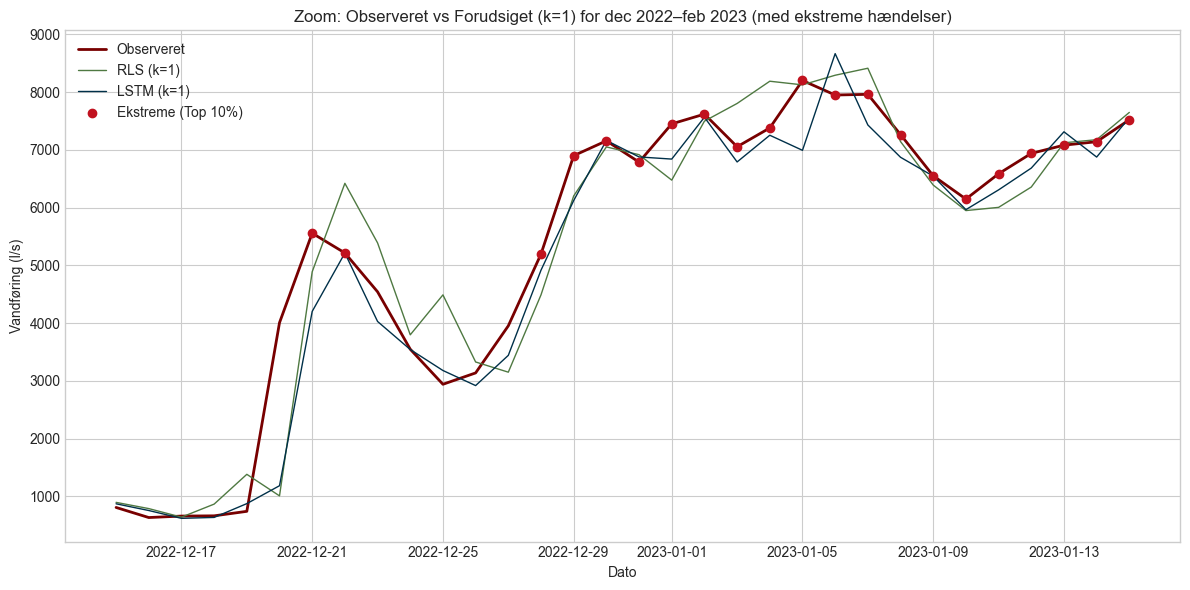

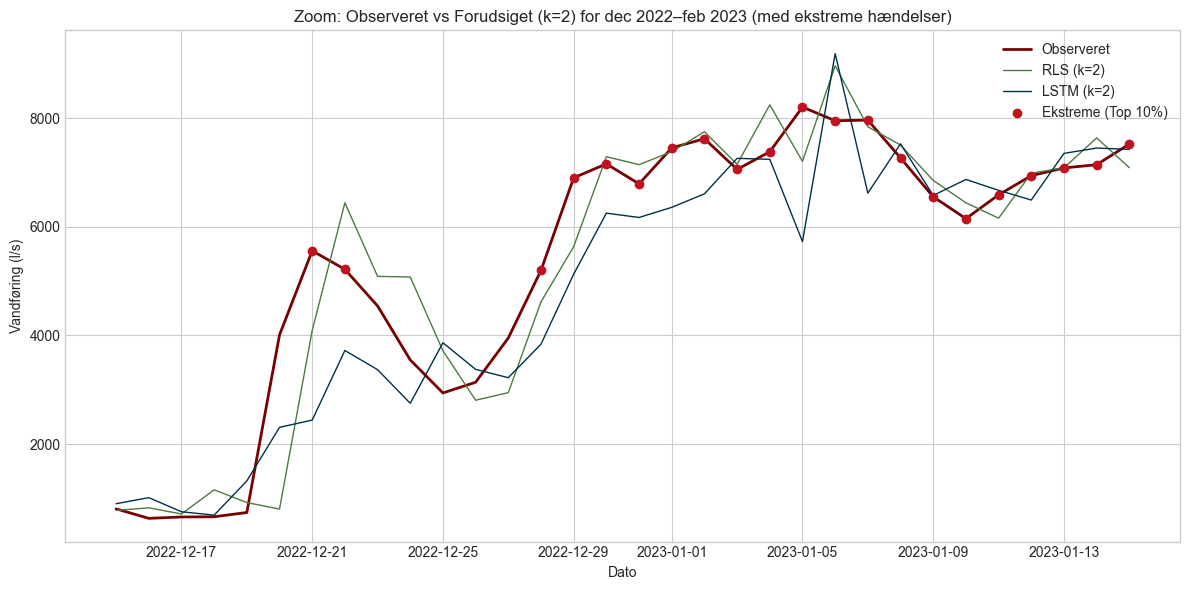

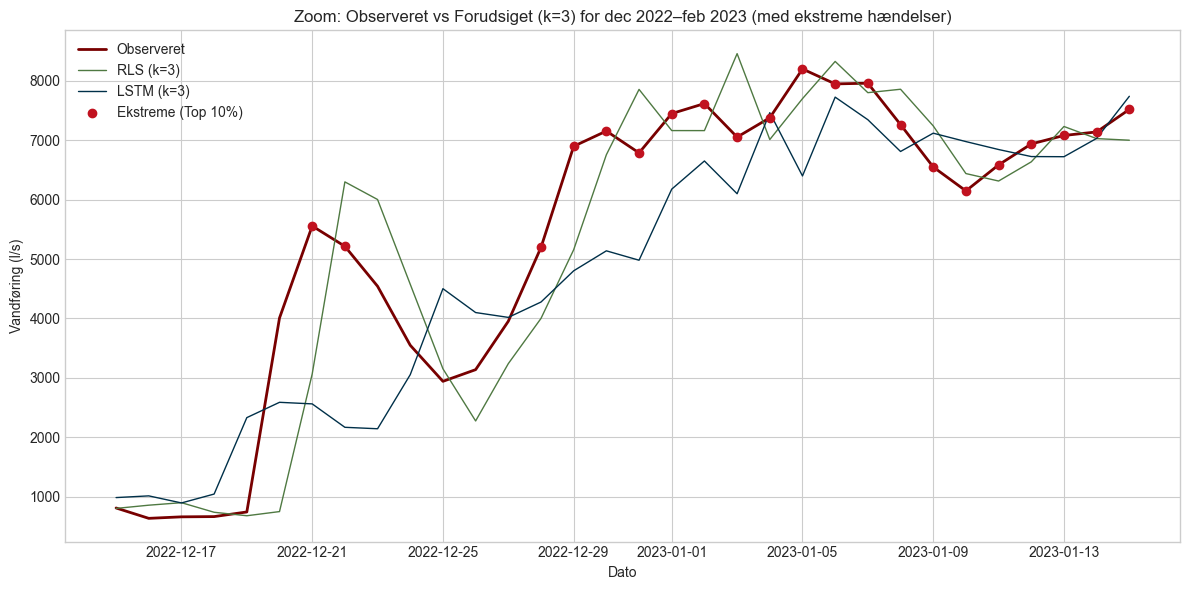

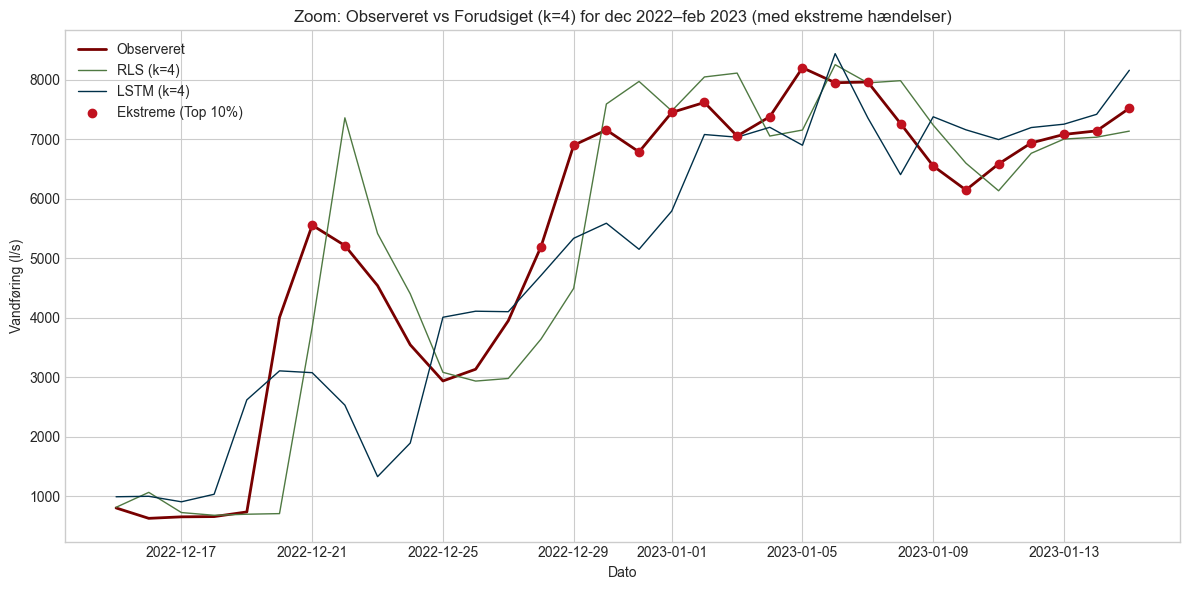

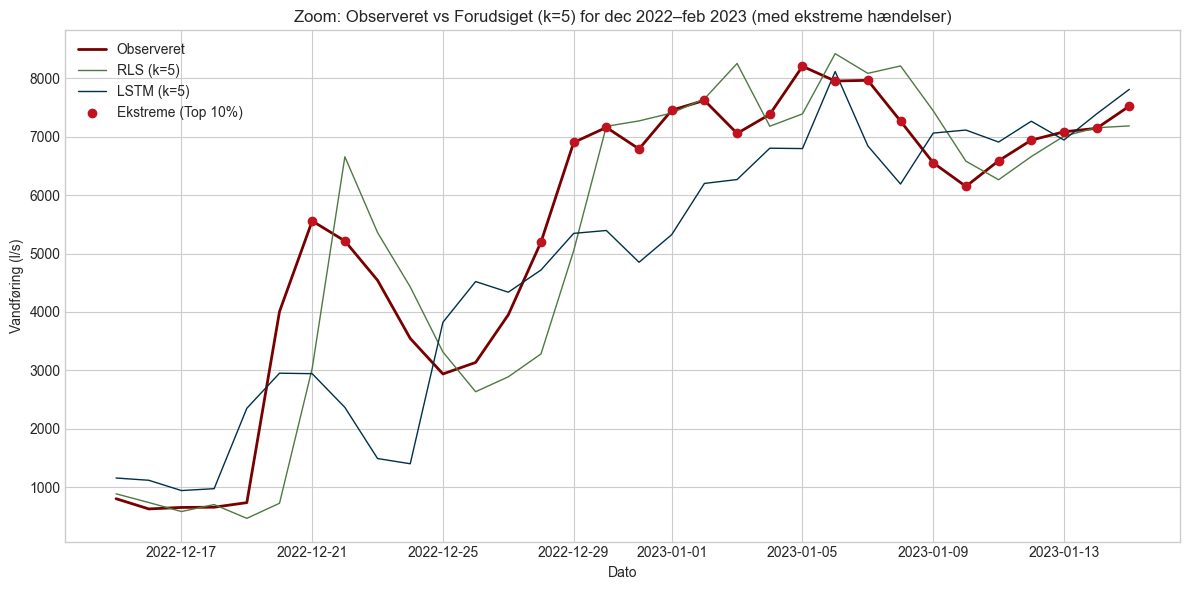

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definér zoom-periode
start, end = '2022-12-15', '2023-01-15'
mask_zoom = (D_time_indexed.index >= start) & (D_time_indexed.index <= end)

# Genbrug threshold fra din score-periode
threshold = np.percentile(D_time_indexed.loc[score_period, 'y'], 90)

# Mask for ekstreme events i zoom-intervallet
mask_extreme_zoom = mask_zoom & (D_time_indexed['y'] >= threshold)

# Loop over horizons 2–5
for k in range(1, 6):
    key = f'k{k}'
    lstm_k = final_lstm_forecasts[key].reindex(D_time_indexed.index)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Observeret
    ax.plot(
        D_time_indexed.loc[mask_zoom, 'y'],
        label='Observeret',
        color=colors['barn_red'],
        linewidth=2
    )
    
    # RLS forudsigelse
    ax.plot(
        YhatR.loc[mask_zoom, key],
        label=f'RLS (k={k})',
        color=colors['fern_green'],
        linewidth=1
    )
    
    # LSTM forudsigelse
    ax.plot(
        lstm_k.loc[mask_zoom],
        label=f'LSTM (k={k})',
        color=colors['prussian_blue'],
        linewidth=1
    )
    
    # Scatter ekstrem-punkter
    ax.scatter(
        D_time_indexed.index[mask_extreme_zoom],
        D_time_indexed['y'][mask_extreme_zoom],
        color=colors['fire_brick'],
        label='Ekstreme (Top 10%)',
        zorder=5
    )
    
    ax.set_xlabel('Dato')
    ax.set_ylabel('Vandføring (l/s)')
    ax.set_title(f'Zoom: Observeret vs Forudsiget (k={k}) for dec 2022–feb 2023 (med ekstreme hændelser)')
    ax.legend()
    plt.tight_layout()
    plt.show()


CSI for Persistence Forecasts: [0.7226890756302521, 0.553030303030303, 0.4642857142857143, 0.3945578231292517, 0.3576158940397351]
CSI for RLS Forecasts: [0.8198198198198198, 0.5736434108527132, 0.45652173913043476, 0.3835616438356164, 0.3624161073825503]
CSI for LSTM Forecasts: [0.8571428571428571, 0.5811965811965812, 0.5245901639344263, 0.4262295081967213, 0.3923076923076923]


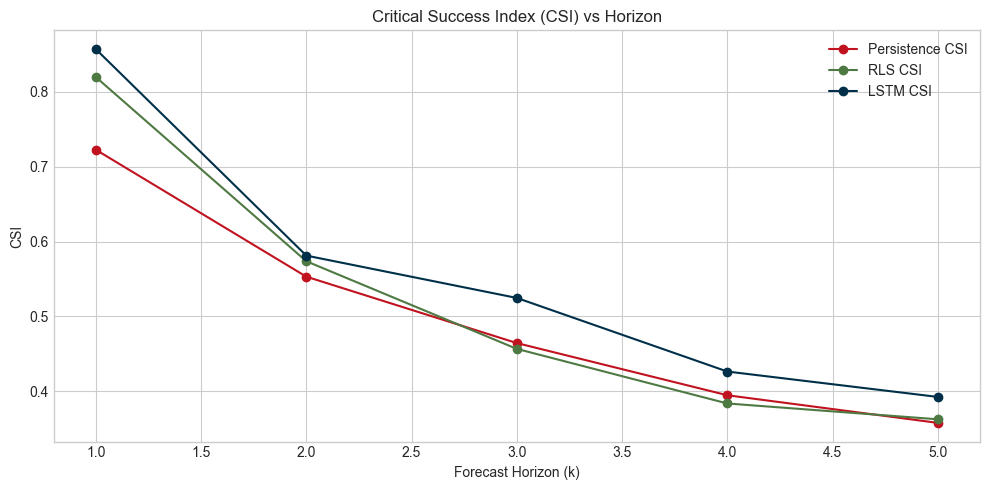

In [2]:
##########################################
# Compute and Plot CSI for Each Model
##########################################
# Define CSI function for binary events
def compute_csi(y_true, y_pred, threshold):
    # Binary events: 1 if value >= threshold, else 0
    obs = (y_true >= threshold).astype(int)
    pred = (y_pred >= threshold).astype(int)
    tp = np.sum((obs == 1) & (pred == 1))
    fn = np.sum((obs == 1) & (pred == 0))
    fp = np.sum((obs == 0) & (pred == 1))
    # CSI = TP / (TP + FN + FP)
    return tp / (tp + fn + fp) if (tp + fn + fp) > 0 else np.nan

# Calculate CSI across horizons
csi_P = []
csi_R = []
csi_L = []
for k in horizons:
    # Observed and forecasts for horizon k on score period
    y_obs = D['y'].shift(-(k-1)).loc[score_period]
    y_pred_P = YhatP[f'k{k}'].loc[score_period]
    y_pred_R = YhatR[f'k{k}'].loc[score_period]
    y_pred_L = final_lstm_forecasts[f'k{k}'].reindex(score_period)
    # compute CSI for each
    csi_P.append(compute_csi(y_obs.values, y_pred_P.values, threshold))
    csi_R.append(compute_csi(y_obs.values, y_pred_R.values, threshold))
    csi_L.append(compute_csi(y_obs.values, y_pred_L.values, threshold))


# Print out values
print("CSI for Persistence Forecasts:", csi_P)
print("CSI for RLS Forecasts:", csi_R)
print("CSI for LSTM Forecasts:", csi_L)

# Plot CSI vs Horizon
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(horizons, csi_P, marker='o', label='Persistence CSI', color=colors['fire_brick'])
ax.plot(horizons, csi_R, marker='o', label='RLS CSI', color=colors['fern_green'])
ax.plot(horizons, csi_L, marker='o', label='LSTM CSI', color=colors['prussian_blue'])
ax.set_xlabel('Forecast Horizon (k)')
ax.set_ylabel('CSI')
ax.set_title('Critical Success Index (CSI) vs Horizon')
ax.legend()
plt.tight_layout()
plt.show()

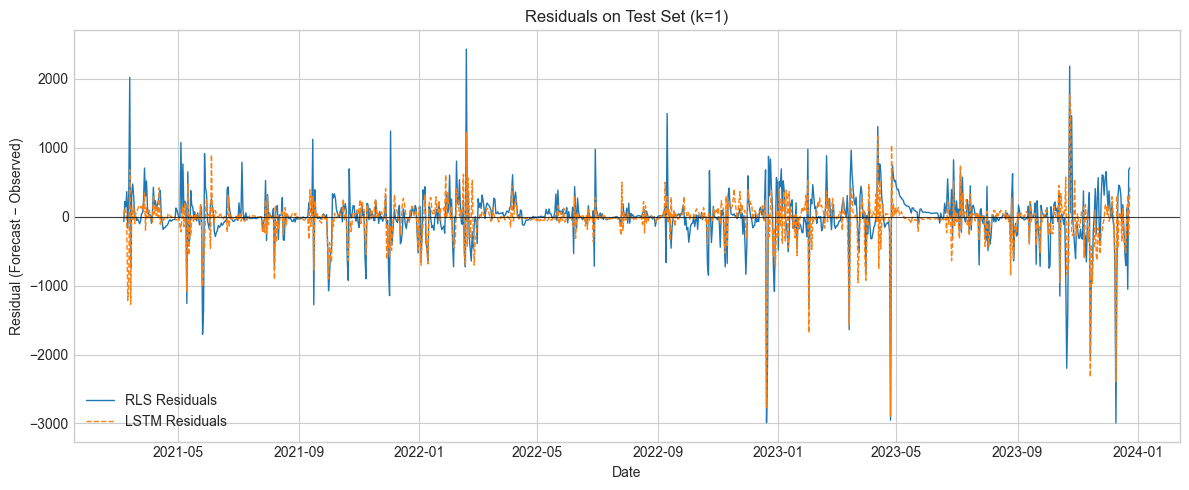

Mean RLS residual (all test):   1.770
Mean LSTM residual (all test): -31.197



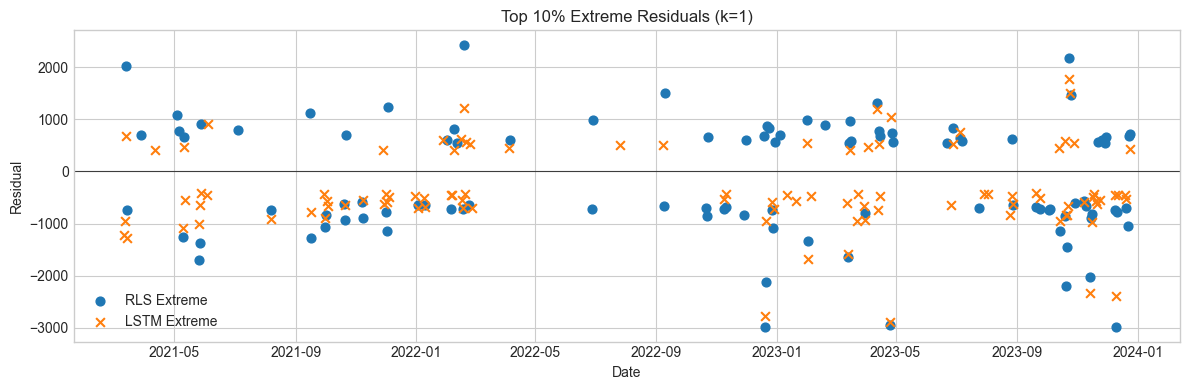

Mean RLS residual (top 10%):   -157.962
Mean LSTM residual (top 10%): -375.494


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Residual Calculation (k=1)
# -------------------------------
# Define test set mask
mask_test = D.index >= score_start

# Align indices for RLS and truth
idxs_test = D.index[mask_test]
y_true_test = D.loc[idxs_test, 'y']

# RLS residuals
res_rls = YhatR.loc[idxs_test, 'k1'] - y_true_test

# LSTM residuals (final_lstm_forecasts only contains test indices)
res_lstm = final_lstm_forecasts['k1'].reindex(idxs_test) - y_true_test

# -------------------------------
# Overall Residual Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(idxs_test, res_rls, label='RLS Residuals', linestyle='-', linewidth=1)
ax.plot(idxs_test, res_lstm, label='LSTM Residuals', linestyle='--', linewidth=1)
ax.axhline(0, color='black', linewidth=0.8, alpha=0.7)
ax.set_title('Residuals on Test Set (k=1)')
ax.set_xlabel('Date')
ax.set_ylabel('Residual (Forecast − Observed)')
ax.legend()
plt.tight_layout()
plt.show()

# Compute mean residuals
mean_rls_all = res_rls.mean()
mean_lstm_all = res_lstm.mean()

print(f"Mean RLS residual (all test):   {mean_rls_all:.3f}")
print(f"Mean LSTM residual (all test): {mean_lstm_all:.3f}\n")

# -------------------------------
# Top 10% Extreme Events
# -------------------------------
# Thresholds for absolute residuals
thr_rls   = np.percentile(np.abs(res_rls),   90)
thr_lstm = np.percentile(np.abs(res_lstm), 90)

# Select extreme events
ext_rls   = res_rls[np.abs(res_rls) >= thr_rls]
ext_lstm = res_lstm[np.abs(res_lstm) >= thr_lstm]

# Plot extreme residuals
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(ext_rls.index,   ext_rls,   label='RLS Extreme',   marker='o', s=40)
ax.scatter(ext_lstm.index, ext_lstm, label='LSTM Extreme', marker='x', s=40)
ax.axhline(0, color='black', linewidth=0.8, alpha=0.7)
ax.set_title('Top 10% Extreme Residuals (k=1)')
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.legend()
plt.tight_layout()
plt.show()

# Compute mean residuals for extremes
mean_rls_ext   = ext_rls.mean()
mean_lstm_ext = ext_lstm.mean()

print(f"Mean RLS residual (top 10%):   {mean_rls_ext:.3f}")
print(f"Mean LSTM residual (top 10%): {mean_lstm_ext:.3f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Residual Calculation (k=1)
# -------------------------------
# Define test set mask
mask_test = D.index >= score_start

# Align indices for RLS and truth
idxs_test = D.index[mask_test]
y_true_test = D.loc[idxs_test, 'y']

# RLS residuals
res_rls = YhatR.loc[idxs_test, 'k1'] - y_true_test

# LSTM residuals
res_lstm = final_lstm_forecasts['k1'].reindex(idxs_test) - y_true_test

# ---------------------------------------------------
# Funktion til at beregne RMSE på en række residualer
# ---------------------------------------------------
def rmse(series):
    return np.sqrt(np.mean(series**2))

# ---------------------------------------------------
# 1) RMSE for første og sidste halvdel
# ---------------------------------------------------
n = len(idxs_test)
halv = n // 2

# Ved positionel opdeling (iloc)
res_rls_first  = res_rls.iloc[:halv]
res_rls_second = res_rls.iloc[halv:]
res_lstm_first  = res_lstm.iloc[:halv]
res_lstm_second = res_lstm.iloc[halv:]

print("=== RMSE for halve ===")
print(f"RLS RMSE (første halvdel):  {rmse(res_rls_first):.3f}")
print(f"RLS RMSE (sidste halvdel):   {rmse(res_rls_second):.3f}")
print(f"LSTM RMSE (første halvdel): {rmse(res_lstm_first):.3f}")
print(f"LSTM RMSE (sidste halvdel):  {rmse(res_lstm_second):.3f}\n")

# ---------------------------------------------------
# 2) RMSE for hver fjerdedel (valgfrit)
# ---------------------------------------------------
q = n // 4
quarters = {
    '1. fjerdedel': slice(0, q),
    '2. fjerdedel': slice(q, 2*q),
    '3. fjerdedel': slice(2*q, 3*q),
    '4. fjerdedel': slice(3*q, n)
}

print("=== RMSE for fjerdedele ===")
for navn, sl in quarters.items():
    rls_q  = res_rls.iloc[sl]
    lstm_q = res_lstm.iloc[sl]
    print(f"{navn}:")
    print(f"  RLS RMSE:  {rmse(rls_q):.3f}")
    print(f"  LSTM RMSE: {rmse(lstm_q):.3f}\n")


=== RMSE for halve ===
RLS RMSE (første halvdel):  316.481
RLS RMSE (sidste halvdel):   449.255
LSTM RMSE (første halvdel): 285.341
LSTM RMSE (sidste halvdel):  399.883

=== RMSE for fjerdedele ===
1. fjerdedel:
  RLS RMSE:  342.058
  LSTM RMSE: 295.833

2. fjerdedel:
  RLS RMSE:  289.325
  LSTM RMSE: 275.029

3. fjerdedel:
  RLS RMSE:  397.690
  LSTM RMSE: 380.630

4. fjerdedel:
  RLS RMSE:  494.179
  LSTM RMSE: 417.300

